#WomboCombo: Optimizing Team Composition in League of Legends
### by Data of Legends (Sean Cha, Jaemin Cheun, Kenny Lei, Andrew Paek) 
###Assigned TF: Léandra King

<img src="http://36646d87786feafc0611-0338bbbce19fc98919c6293def4c5554.r0.cf1.rackcdn.com/images/FiGZ9r3D3E82.878x0.Z-Z96KYq.jpg" width=610 height=347/>

#Table of Contents

* [WomboCombo: Optimizing Team Composition in League of Legends](#WomboCombo: Optimizing Team Composition in League of Legends)
	* [Introduction](#Introduction)
		* [Different Roles](#Different Roles)
        * [Objectives](#Objectives)
	* [Part I: Data Retrieval & Cleaning](#Part-I-Data-Retrieval-&-Cleaning)
		* [League of Legends API](#LoL-API)
        * [Pulling and Saving JSON Files](#JSON-Files)
		* [Pre-processing Data](#pre-processing)
		* [Feature Selection](#feature-selection)
        * [Parsing JSON into a csv](#parsing)
    * [Part II: Exploratory Data Analysis (EDA)](#EDA)
		* [Rank Tier and Region Distribution](#tier-region-dist)
		* [Most Popular Champions](#popular_champ)
        * [Win/Loss Rate Based on Champion](#win_loss_rate)
        * [KDA by Champion](#KDA)
        * [Champions by Stat](#champion-stat)
    * [Part III: Clustering Algorithms](#clustering)
        * [Standardization](#standardization)
		* [Making baseline predictions](#Making-baseline-predictions)
			* [1.3 Make the prediction from the `baseline` model](#1.3-Make-the-prediction-from-the-baseline-model)        

##Introduction <a id='Introduction'></a>

League of Legends (LoL) is currently the most popular game in the world. LoL is a fast-paced, competitive online game that blends the speed and intensity of an RTS with RPG elements. Two teams of 5 powerful champions, each with a unique design and playstyle, battle head-to-head across multiple battlefields and game modes. With an ever-expanding roster of champions, frequent updates and a thriving tournament scene, League of Legends offers endless replayability for players of every skill level.

The main objective of the game is to knock down the enemies' towers using the champions, while the enemy team is trying to do the same to ours. Towers are difficult to destroy with the enemy defending them, so most of the game revolves around killing enemy champions in order to buy the necessary time to bring down enemy towers.

Team composition is extremely important in the game. Each champion out of the roster of 128 (and growing!) carries its own unique abilities, utility, and play style that it can contribute to the team. Simply put, a team of 5 champions that share similar roles in the game would be very ineffective against a well-balanced team. Let's look at some examples.

### Different Roles <a id='Different Roles'></a>
This is LeBlanc. Her primary role in the game is an assassin. She has an extremely low physical damage power (red bar) and low health (green bar). However, she has a HUGE ability power (blue bar), allowing her to use quick burst of ability power to kill enemies in a split second. She is extremely effective in assassinating enemy champions that are roaming around the map by themselves. Since her abilities have a very long cool-down (time for her to be able to cast spells again), she is in deep trouble if she cannot kill the enemy champion the first time around. In a team fight, LeBlanc focuses on killing high priority enemy champions. This is an old video from a few seasons back, but it really demonstrates what LeBlanc is capable of: https://www.youtube.com/watch?v=lsBJEvwi66k.
<img src=http://i.imgur.com/G5jbBpq.png>

This is Malphite. His primary role is a tank. He has high health and defensive statistics, allowing him to last a long time in a team fight. Although he cannot quickly kill enemy champions the way LeBlanc does, he is able to follow around and harrass/interrupt high-priority enemy champions in their attempts to kill ours. He is also an "utility" champion, meaning that he has various "crowd-controlling" abilities that slow down and knocks up enemy champions, making it easier for our champions to target them. This is an example of Malphite's specialty in initiating a team fight and tankiness: https://youtu.be/pE3aLnoB7oA?t=17m53s.
<img src=http://i.imgur.com/POWWt9u.png>

These are only 2 of the 128 champions that players can choose to play. As you can see, LeBlanc and Malphite have very distinctly different roles in the game. It would be a disaster for a team to have 5 "tank" champions, since tanky champions, despite their resilience, cannot deal enough damage to kill enemy champions. A team of only assassins will also have no luck in winning; without a reliable tanker to take the frontline and disrupt the enemy, the LeBlancs will quickly "evaporate to death."

This is where team composition comes in. A team that has both a Malphite and a LeBlanc will be extremely effective. While Malphite slows down enemies and takes all the damages, LeBlanc can focus on dealing massive magic damage to the enemy champions. Other notable roles include that of a fighter (a champion that can deal consistent damage over time while taking moderate damage), a support (a champion specializing in crowd control abilities to disable enemy champions and healing to protect our champions), a marksman (a range-attack champion who is extremely vulnerable but can deal a massive amount of damage from a distance), etc.

Certain set of champions complement each other really well, thus the coinage of the term, Wombo Combo. To look at some examples of Wombo Combos, please see: https://www.youtube.com/watch?v=TW6bdxnFcjs

###Objectives <a id='Objectives'></a>

We hope to gain insight on optimal team composition by analyzing match data.

First, we use Riot's League of Legends API (https://developer.riotgames.com/docs/rate-limiting) to download the necessary data. Then, we preprocess and clean the raw JSON data to a workable structure.

Next, we conduct Exploratory Data Analysis (EDA) to answer some basic questions regarding our data set. By visualizing and playing around with the data, we gain additional insight that will be helpful in later parts.

Then, we ... (WRITE ABOUT ALGORITHMS HERE)

In [1]:
%matplotlib inline
import os
import json
import requests
import time
import datetime
import types
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

##Part I: Data Retrieval & Cleaning<a id='Part-I-Data-Retrieval-&-Cleaning'></a>

### League of Legends API <a id='LoL-API'></a>

Rate Limiting: The API allows one user to make 10 requests per 10 seconds and 500 requests per 10 minutes.

For documentation, see https://developer.riotgames.com/api/methods.

From the riot games API page,  
<b>"The rate limit for development keys is by design very limited:   
10 requests every 10 seconds  
                                                                500 requests every 10 minutes" </b>

However,

<b>"Note that rate limits are enforced per region. For example, with the above rate limit, you could make 10 requests every 10 seconds to both NA and EUW endpoints simultaneously."</b>

If we try to only stick to North American server data, we will have to wait 10 seconds for every 10 requests. This would be very unfortunately inefficient. However, if we pull data from all of LoL's 10 global regions, we can continuously pull data without the rate limit's hinderance. When we reach the limit, we'll just jump regions!

There may be slight variations in popular game styles from region to region. But keep in mind that LoL is a same game no matter where in the world you are. Whenever there is a champion update or an item patch, the entire world's LoL platform is updated simultaneously.

In [2]:
# API KEY HERE
KEY = 'b00c992b-6fc1-4795-abcc-7db85c1b72fa' # API Key associated with Sean's LoL account (ch920425)

We define a function that makes a request for a match record by its matchID.

In [3]:
# MATCH-v2.2
REGION_ENDPOINT = "https://{0}.api.pvp.net/api/lol/{0}/"

# FUNCTION TO PULL MATCH DATA
def get_match(REGION, matchId, includeTimeline):
    """
    Retrieve match by match ID.
    """
    return requests.get(
        (REGION_ENDPOINT + "v2.2/match/{1}?"
         "api_key={2}&includeTimeline={3}").
        format(REGION, matchId, KEY, includeTimeline))

We establish constants that allow us to check whether we are within the API's rate limit. 

We define several functions that allow us to filter out the data we want.

There are different "game modes" and "queue types" in League of Legends. We only want to look at the most popular type people play, which are "classic" 5v5 match on a map called Summoner's Rift. We also want to only look at "Ranked" games, which affect the player's scores and ranking within the gaming ecosystem. In Ranked games, people are motivated to put in their best efforts to advance to higher tier systems. Simply put, classic ranked game data will manifest champion selections and play styles that players themselves would find optimal. We want to capture this optimally conventionally play style and find patterns.

However...

API Limitations: The API does not allow us to specify what type of game mode or queue type we want to pull. There is no real distinguishable pattern within matchID's neither. We will have to pick a starting point (an arbitrary matchID), increment the ID by 1, pull the data, check to see whether it satisfies our requirements, and then decide to store it.

This process does take a long time. We have run the scripts to selectively pull data this way for days and nights on multiple machines.

In [2]:
# Constants
STATUS_OK = 200                  # Shows that we have successfully pulled data
STATUS_RATE_LIMIT_EXCEEDED = 429 # Tells us that we have to wait 10 seconds before requesting again

# Region Servers from which to retrieve data
# North America, Korea, Europe Nordic and East, Europe West, Latin America 
REGION_list = ['na',     # North America
               'kr',     # Korea
               'eune',   # Europe Nordic and East
               'euw',    # Europe West
               'lan',    # Latin America North
               'las',    # Latin America South
               'oce',    # Oceania
               'ru',     # Russia
               'br',     # Brazil
               'tr']     # Turkey

# Only interested in 5v5 RANKED games
valid_rank_games = ['RANKED_SOLO_5x5',     # Ranked Solo 5v5 games
                    'RANKED_PREMADE_5x5',  # Ranked Premade 5v5 games
                    'RANKED_TEAM_5x5']     # Ranked Team 5v5 games

# Functions that check status of the data pulls
def isValid(match):
    if match.status_code != STATUS_OK:
        return False
    return True

# We only look at 'MATCHED_GAME' since 'CUSTOM_GAME' is where people try experimental champions and play styles
def isClassicMatch(match):
    j = match.json()
    if j['mapId'] == 11 and j['matchMode'] == "CLASSIC" and j['matchType'] == 'MATCHED_GAME':
        return True
    else:
        return False

# Checking if ranked game
def isRankMatch(match):
    j = match.json()
    if j['queueType'] in valid_rank_games:
        return True
    else:
        return False

# Check whether we went over the API Rate Limit                     
def rateLimitExceeded(match):
    if int(match.status_code) == STATUS_RATE_LIMIT_EXCEEDED:
        return True
    return False

### Pulling and Saving JSON Files <a id='JSON-Files'></a>
As mentioned above, matchID's do not have a defining pattern. For the most part, they seem to increase incrementally and similar game modes/types seem to be clustered around. Other times, they are long succession of empty numbers (404 status where there is no game stored for that matchID).

We start with a region (ex. North America) and a match ID from that region. We first have a list of matchID's of the world's high-ranked players' recent match history. 

In [5]:
# List of starting MatchID's for each region was found by looking up skilled players and their recent games
# on this website: http://www.lolsummoners.com/ladders/
regional_match_id = {'br': 667070831,
                     'eune': 1297476531,
                     'euw': 2416867378,
                     'kr': 2192854102,
                     'lan': 229958232,
                     'las': 273070421,
                     'na': 2029999649,
                     'oce': 113870290,
                     'ru': 84050671,
                     'tr': 325244412}

Then, we pull the matchID, examine it to see if it meets our criteria, and save it to as a JSON file if it does. Then, we increment the matchID and continue the process. Once we reach the rate limit for the region, we move onto the next region and continue the same process. Going through all 10 regions make it so that we are not limited by the rate limit. By the time we make a way around the world (all 10 regions), the rate limit time of 10 seconds for the first region has already passed. Thus, we do not have to waste any time waiting for the API to 'clear' us.

The data is saved in JSON format one by one in '/dump' sub-directory. Each JSON file is named by the region marker followed by the matchID.

Although it would be very unlikely given that matchID's are 10-digit numbers, we add a region marker in front of each matchID to make sure same matchID's from different regions do not overwrite one another.

In [42]:
# We modified the code from https://github.com/LionTurtle/TeamCompML/

# initializing indices
i, n, r = (0, 0, 0) # i = incrementing starting match ID, n = number of games retrieved, r = region list index)

# We keep the range low here for demonstration purposes. 
# In reality, we set the range to 100,000 and let it run days and nights
for k in range(100):
    
    # current region
    curr_region = REGION_list[r]
    
    # increment match ID of the current region
    current_match_id = regional_match_id[curr_region] + i
    i += 1
    
    # use the API function to receive information on this current_match_id minus timeline data
    m = get_match(curr_region, current_match_id, False)
    
    if not rateLimitExceeded(m):
        if isValid(m) and isClassicMatch(m) and isRankMatch(m):
            # we add curr_region marker in front of the current_match_id when naming the files
            f = open("dump_global/" + str(curr_region) + str(current_match_id) + ".json", 'w+')
            f.write(m.text.encode('utf-8'))
            n += 1
            print 'n: %d, ts: %s, ID: %d, date: %s, season: %s, tier: %s, loop_index: %d, region: %s' % (n, datetime.datetime.fromtimestamp(time.time()).strftime('%H:%M:%S'), 
                                                                                                 current_match_id, 
                                                                                                 ('%s' % (time.strftime('%m-%d', time.localtime(m.json()['matchCreation']/1000)))),
                                                                                                 m.json()['season'], m.json()['participants'][1]['highestAchievedSeasonTier'], k,
                                                                                                            m.json()['region'])
            f.close()
    else:  
        # we save the new match id (incremented match id) to pick up pulling data for when the next cycle comes around
        regional_match_id[curr_region] =  current_match_id + i
        
        # when we reach the rate limit for the region, we move onto the next region on the list
        if (r == 9):
            # go back to the beginning of the list of regions and start the cycle again
            print ("rate limit reached at %s, moving onto %s") % (REGION_list[r], REGION_list[0])
            r = 0
        else:
            print ("rate limit reached at %s, moving onto %s") % (REGION_list[r], REGION_list[r+1])
            r += 1
        # reset the incrementer    
        i = 0

n: 1, ts: 20:51:59, ID: 2029999649, date: 12-06, season: PRESEASON2016, tier: GOLD, loop_index: 0, region: NA
n: 2, ts: 20:52:00, ID: 2029999651, date: 12-06, season: PRESEASON2016, tier: UNRANKED, loop_index: 2, region: NA
n: 3, ts: 20:52:01, ID: 2029999652, date: 12-06, season: PRESEASON2016, tier: PLATINUM, loop_index: 3, region: NA
n: 4, ts: 20:52:03, ID: 2029999656, date: 12-06, season: PRESEASON2016, tier: GOLD, loop_index: 7, region: NA
rate limit reached at na, moving onto kr
n: 5, ts: 20:52:12, ID: 2192854110, date: 12-06, season: PRESEASON2016, tier: SILVER, loop_index: 19, region: KR
rate limit reached at kr, moving onto eune
n: 6, ts: 20:52:18, ID: 1297476540, date: 12-06, season: PRESEASON2016, tier: PLATINUM, loop_index: 31, region: EUNE
rate limit reached at eune, moving onto euw
rate limit reached at euw, moving onto lan
rate limit reached at lan, moving onto las
rate limit reached at las, moving onto oce
n: 7, ts: 20:52:37, ID: 113870297, date: 12-02, season: PRESEASON

### Pre-processing Data <a id='pre-processing'></a>

Let's take a look at what the JSON files look like. It has a bunch of metrics that we won't use. We will focus on the in-game stats broken down by participant (player) that give us a quantitative overview of the person's play style and performance. 

In [7]:
test_response = get_match('na', 2026610783, False).json()
# let's take a look at what it looks like
print test_response

{u'queueType': u'RANKED_TEAM_5x5', u'matchVersion': u'5.23.0.239', u'platformId': u'NA1', u'season': u'PRESEASON2016', u'region': u'NA', u'matchId': 2026610783, u'mapId': 11, u'matchCreation': 1449099999881, u'teams': [{u'firstDragon': False, u'bans': [{u'pickTurn': 1, u'championId': 203}, {u'pickTurn': 3, u'championId': 41}, {u'pickTurn': 5, u'championId': 420}], u'firstInhibitor': False, u'baronKills': 0, u'firstRiftHerald': False, u'winner': True, u'firstBaron': False, u'riftHeraldKills': 1, u'firstBlood': True, u'teamId': 100, u'firstTower': False, u'vilemawKills': 0, u'inhibitorKills': 0, u'towerKills': 6, u'dominionVictoryScore': 0, u'dragonKills': 1}, {u'firstDragon': True, u'bans': [{u'pickTurn': 2, u'championId': 117}, {u'pickTurn': 4, u'championId': 16}, {u'pickTurn': 6, u'championId': 223}], u'firstInhibitor': False, u'baronKills': 0, u'firstRiftHerald': True, u'winner': False, u'firstBaron': False, u'riftHeraldKills': 1, u'firstBlood': False, u'teamId': 200, u'firstTower': 

Oh, boy. That's a big jumble of text! 

Before we start making csv files of nicely organized data of the JSON files, we make a function that converts a championID to champion name. Our raw data denotes each champion by its championID, which is just a random number.

In [8]:
########## Champion ID to Champion Name converter ##########

# GET the static data on champion keys and names
static_champ_data = requests.get("https://global.api.pvp.net/api/lol/static-data/na/v1.2/champion?locale=en_US&api_key=%s"%KEY).json() 
champs = static_champ_data['data']
champ_names = static_champ_data['data'].keys()

# initializing index and empty dictionaries
i = 0
list_champs = []
list_champ_ids = []

# filling in the lists
for i in range(len(champ_names)):
    this_champ = champs[champ_names[i]]
    list_champs.append(this_champ['key'])
    list_champ_ids.append(this_champ['id'])
    
# champion ID and name dictionary    
champ_dict = dict(zip(list_champ_ids, list_champs))

# Wukong's name is not correct (MonkeyKing)
champ_dict[62] = 'Wukong'

# function that converts a champion ID to champion name
def champion_name(champion_id):
    if champion_id in champ_dict:
        return champ_dict[champion_id]
    else:
        return 'no_name'

In [9]:
# Let's checkout what champions 3 and 64 are
print champion_name(3)
print champion_name(64)

Galio
LeeSin


Now that we have a bunch of JSON files. Let's put them into usable form. We will merge all the necessary data from the JSON files to a giant csv file for easy access. Each game has 10 players (thus champions) and thus will have 10 rows of data. Each game and its participants are identifiable by the match ID. 

This part takes a few minutes to run depending on how much data we have on hand.

In [10]:
# Helper functions to parse data into a csv file
def insertComma(fileName):
    fileName.write(' , ')

def writetoFile(fileName,data):
    fileName.write(str(data))
    insertComma(fileName)

### Feature Selection<a id='feature-selection'></a>
The retrieved data gives us A LOT of statistics and metrics regarding the player and what happened in that game. However, we only want to work with the most important, dividing features that will facilitate the clustering process as well as CURSE OF DIMENSIONALITY.

The following list are the features we decided to keep and the reasoning behind each of them. Using our domain knowledge of the game, we believe that these features would be important in differentiating the roles of different champions once we get to clustering.

##### General Info for Labeling and Group-by Operations (not used for clustering later)
<b>match_ID</b>: unique match ID; tells us what game to which the statistics belong  
<b>participan</b>t: general participant identifier within the game (1~10)  
<b>champ</b>: name of the participant's champion    

##### Relevant In-game Stats
<b>win</b>: boolean flag for winning team and losing team (0,1)  
<b>kills</b>: number of kills the champion had during game    
<b>assists</b>: number of assist kills the champion had during game  
<b>deaths</b>: number of times the champion died in the game    
<b>gold_earned</b>: amount of gold earned throughout the game    
<b>p_damage_to_champs</b>: physical damage dealt to enemy champions (AD: attack damage)    
<b>m_damage_to_champs</b>: magic damage dealt to enemy champions (AP: ability power)  
<b>max_multi_kill</b>: the highest multi kill achieved (ex. 5 -> pentakill, where one champion has wiped out the entire enemy team)  
<b>max_crit</b>: highest critical physical damage dealt by the champion  
<b>damage_taken</b>: the amount of damage that the champion received  
<b>no_killing_spree</b>: number of consecutive kills before dying  
<b>creep_score</b>: number of minions killed  
<b>jungle_killed</b>: number of neutral jungle monsters killed  
<b>cc_dealt</b>: metric that tells how much crowd-control (cc) effect was dealt to enemy champions  
<b>wards_placed</b>: number of sight wards placed on the map  
<b>total_heal</b>: amount of healing done to me or teammates excluding lifesteal, natural health regeneration, and potions

We believe that these features are defining characteristics of champion roles. For example, an attack-damage (AD) based assassin/fighter such as Master Yi will have high <b>max_crit</b> and <b>max_multi_kill</b>. Since he does not have innate crowd-control abilities, he will have near 0 <b>cc_dealt</b> stat. Once we start clustering, we predict that he will be in a cluster with other similar champions who rely on short burst of physical attack damage.

To give another example of how these features may help, let's look back at the example of Malphite we saw above. Malphite, as mentioned, mostly functions as a tanker. He will thus be in the cluster characterized by high <b>damage-taken</b> and high <b>cc_dealt</b> given that he is designed to endure a lot of damage and has several crowd-control abilities.

### Parsing JSON file into a CSV file <a id='parsing'></a>

Now we go through the JSON files in our directory, pull out the relevant data, and save them into an aggregated csv file.

Each row represents a player's match record. Since there are 10 people in a match, each file we downloaded should give us 10 rows of data to work with.

This gives us one simple file we can rely on to play with!

In [204]:
# helper function for determining match_tier
def most_common(lst):
    return max(((item, lst.count(item)) for item in set(lst)), key=lambda a: a[1])[0]

In [205]:
# We modified the code from https://github.com/LionTurtle/TeamCompML/

# directory with all the JSON files
DUMP_DIR = 'dump_global/'
counter = 0
# the csv file where we are saving everything
unnormalized_data = open('unnormalized.csv','w+')
# column names (the features above)
unnormalized_data.write('region,match_ID,participant,rank,match_rank,champ,win,kills,assists,deaths,gold_earned,p_damage_to_champs,m_damage_to_champs,max_multi_kill,max_crit,damage_taken,no_killing_spree,creep_score,jungle_killed,cc_dealt,wards_placed,total_heal\n')        

for f in os.listdir(DUMP_DIR):
    counter += 1
    if (counter % 1000) == 0:
        print "parsed %d files..." % counter
    
    if f.find('json') != -1:
        json_data = open(DUMP_DIR + f)
        data = json.load(json_data)
        json_data.close()

        if len(data['participants']) == 10:  #verify valid game with all players
            counter += 1
            
            rank_list = []
            for i in range(0,10):
                rank_list.append(data['participants'][i]['highestAchievedSeasonTier'])
            match_tier = most_common(rank_list)

            for i in range(0,10):
                teamID = 0 if data['participants'][i]['teamId'] == data['teams'][0]['teamId'] else 1
                stats = data['participants'][i]['stats']

                # General Info -- not used for clustering
                writetoFile(unnormalized_data, data['region'])
                writetoFile(unnormalized_data, data['matchId'])
                writetoFile(unnormalized_data, data['participantIdentities'][i]['participantId'])
                writetoFile(unnormalized_data, data['participants'][i]['highestAchievedSeasonTier'])
                writetoFile(unnormalized_data, match_tier)
                writetoFile(unnormalized_data, champ_dict[data['participants'][i]['championId']])
                
                # indicator for winner
                writetoFile(unnormalized_data, int(data['teams'][teamID]['winner']))
                
                # KDA
                writetoFile(unnormalized_data, stats['kills'])
                writetoFile(unnormalized_data, stats['assists'])
                writetoFile(unnormalized_data, stats['deaths'])
                
                writetoFile(unnormalized_data, stats['goldEarned'])
                writetoFile(unnormalized_data, stats['physicalDamageDealtToChampions'])
                writetoFile(unnormalized_data, stats['magicDamageDealtToChampions'])
                writetoFile(unnormalized_data, stats['largestMultiKill'])
                writetoFile(unnormalized_data, stats['largestCriticalStrike'])
                
                writetoFile(unnormalized_data, stats['totalDamageTaken'])
                writetoFile(unnormalized_data, stats['killingSprees'])
                
                writetoFile(unnormalized_data, stats['minionsKilled'])
                writetoFile(unnormalized_data, stats['neutralMinionsKilled'])
                writetoFile(unnormalized_data, stats['totalTimeCrowdControlDealt'])
                
                writetoFile(unnormalized_data, stats['wardsPlaced'])
                writetoFile(unnormalized_data, stats['totalHeal'])

                unnormalized_data.write('\n')

parsed 1000 files...
parsed 2000 files...
parsed 3000 files...
parsed 4000 files...
parsed 5000 files...
parsed 6000 files...
parsed 7000 files...
parsed 8000 files...
parsed 9000 files...
parsed 10000 files...
parsed 11000 files...
parsed 12000 files...
parsed 13000 files...
parsed 14000 files...
parsed 15000 files...
parsed 16000 files...
parsed 17000 files...
parsed 18000 files...
parsed 19000 files...
parsed 20000 files...
parsed 21000 files...
parsed 22000 files...
parsed 23000 files...
parsed 24000 files...
parsed 25000 files...
parsed 26000 files...
parsed 27000 files...
parsed 28000 files...
parsed 29000 files...
parsed 30000 files...
parsed 31000 files...
parsed 32000 files...
parsed 33000 files...
parsed 34000 files...
parsed 35000 files...
parsed 36000 files...
parsed 37000 files...
parsed 38000 files...
parsed 39000 files...
parsed 40000 files...
parsed 41000 files...
parsed 42000 files...
parsed 43000 files...
parsed 44000 files...
parsed 45000 files...
parsed 46000 files.

##### Putting the data in pandas dataframe

Now we use the csv file to make a pandas dataframe, a format we are familiar with!

In [2]:
# Read the csv file
df = pd.read_csv('final_unnormalized.csv')

# There's a weird column named 'Unnamed: 22'. Let's get rid of it
#del df['Unnamed: 22']

# check column names
columns=np.array(df.columns)
df.dtypes

region                object
match_ID               int64
participant            int64
rank                  object
match_rank            object
champ                 object
win                    int64
kills                  int64
assists                int64
deaths                 int64
gold_earned            int64
p_damage_to_champs     int64
m_damage_to_champs     int64
max_multi_kill         int64
max_crit               int64
damage_taken           int64
no_killing_spree       int64
creep_score            int64
jungle_killed          int64
cc_dealt               int64
wards_placed           int64
total_heal             int64
dtype: object

In [3]:
# Deleting duplicates that may have arised from moving files around
dup_series = df.duplicated(['region', 'match_ID', 'champ'])
duplicates = dup_series[dup_series == True]

df = df.drop(df.index[duplicates.keys()])

#### Adjustments for Season
Riot Games frequently updates LoL, which involves adding new champions, changing champion's skills and stats, and others. This insures that game balance is maintained and a new challenge for players to adapt to new gaming environment.

Every year, a new season starts and ends in the middle of November. The most drastic update is introduced when a new season begins. The time period between November and the following year is called "pre-season," where players get used to the new gaming environment in the upcoming new season.

Since the game play is subtly and sometimes drastically different from season to season and even within the same season, we want to look at a specific time period. Thus, we tried to make sure that all the match data we downloaded were from the same season. Let's make sure that all the matches we downloaded are from pre-season 2016.

In [5]:
# Delete game data from other seasons

#### Current Tier
The "rank" value assigned to each player (participant in the game) is based on that person's highest achieved rank in previous seasons. Unfortunately, our API does not tell us what tier the player is currently in. We will then assume that a player who was in Silver tier in previous seasons is as good as a current Silver tier player. Ranked matches make sure that players who are in similar tiers are matched up. Although a game may have players of all sorts of rank, we will assign an overall "rank" for the match itself. If most of the players in the game are in Diamond tier, we will assign the match_tier Diamond status.

In [4]:
mini_df = df.head(50)
group = mini_df.groupby(['region','match_ID'])['rank']
agg_group = group.agg(lambda x: x.value_counts().index[0].strip())
print agg_group.xs
#agg_group['OCE']
print agg_group.keys()
#df.xs('one', level='second')
#agg_group[['OCE'],[113859173]]
#mini_df.assign(match_rank = lambda x: )

#mini_df['match_rank'] = mini_df.groupby(['region', 'match_ID'])['rank'].agg(lambda x: x.value_counts().index[0].strip())
#mini_df
#df.groupby(['Mt'], sort=False)['count'].max()

<bound method Series.xs of region  match_ID 
OCE     113859173      SILVER
        113859174      BRONZE
        113859179      SILVER
        113859217        GOLD
        113859243    UNRANKED
Name: rank, dtype: object>
MultiIndex(levels=[[u'OCE'], [113859173, 113859174, 113859179, 113859217, 113859243]],
           labels=[[0, 0, 0, 0, 0], [0, 1, 2, 3, 4]],
           names=[u'region', u'match_ID'])


In [5]:
# Make a copy of our data frame
eda_df=df.copy()
eda_df.head(20)

,region,match_ID,participant,rank,match_rank,champ,win,kills,assists,deaths,...,m_damage_to_champs,max_multi_kill,max_crit,damage_taken,no_killing_spree,creep_score,jungle_killed,cc_dealt,wards_placed,total_heal
0,OCE,113859173,1,SILVER,SILVER,MissFortune,0,10,10,7,...,2542,2,878,25178,3,253,18,506,5,4450
1,OCE,113859173,2,SILVER,SILVER,Vladimir,0,12,7,9,...,35581,1,0,47495,4,268,1,667,12,32996
2,OCE,113859173,3,UNRANKED,SILVER,Morgana,0,0,9,7,...,5745,0,0,14913,0,40,0,968,16,140
3,OCE,113859173,4,UNRANKED,SILVER,Akali,0,12,9,13,...,17557,2,0,39497,2,81,0,975,6,598
4,OCE,113859173,5,GOLD,SILVER,XinZhao,0,5,10,12,...,6175,1,173,44762,0,53,52,1852,15,11141
5,OCE,113859173,6,SILVER,SILVER,Tristana,1,9,10,6,...,4333,2,681,24242,2,234,11,144,6,5231
6,OCE,113859173,7,UNRANKED,SILVER,Blitzcrank,1,5,15,7,...,5739,1,0,31238,1,20,1,112,18,5104
7,OCE,113859173,8,SILVER,SILVER,Riven,1,9,10,13,...,0,2,0,32805,1,172,12,237,7,436
8,OCE,113859173,9,GOLD,SILVER,Talon,1,15,8,10,...,243,2,0,35775,3,193,16,877,14,2683
9,OCE,113859173,10,GOLD,SILVER,Nunu,1,10,18,3,...,25176,2,0,54151,3,62,95,2535,17,22512


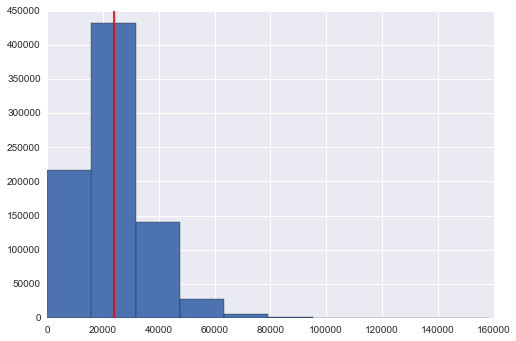

In [6]:
plt.hist(eda_df['damage_taken'])
plt.axvline(np.mean(eda_df['damage_taken']), color='red')

The data frame looks good! We now explore our data.

## Part II: Exploratory Data Analysis (EDA) <a id='EDA'></a>

### Rank Tier and Region Distribution<a id='tier-region-dist'></a>

We have compiled match data from various rank tiers and regions. Let's check out the distribution of those before we move on.

To give a little context, LoL has a <b>rank tier system.</b> When people play "ranked" games (which is what we specifically downloaded), they play with other people who are of similar playing level. Those who have not played enough ranked games are marked to be in "unranked" tier. Then, goes Bronze, Silver, Gold, Platinum, Diamind, Master, and Challenger in order of increasing skill level. The tier system is based on a percentile. The rank tiers are also broken down into divisions (ex. Bronze III, Platinum I, etc.), but we are not concerned about these subvisions for this project.

This helpful website (http://www.leagueofgraphs.com/rankings/rank-distribution) shows that the distribution of tiers are as follows:

Of those players who are considered "ranked,"  
<b>Bronze</b>: &nbsp;&nbsp;&nbsp; 56.5% of the population  
<b>Silver</b>: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 32.5% of the population  
<b>Gold</b>: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;9.1% of the population  
<b>Platinum</b>: &nbsp;&nbsp;&nbsp;&nbsp;1.6% of the population  
<b>Diamond</b>: &nbsp;&nbsp;&nbsp;&nbsp;0.3% of the population  
<b>Master</b>: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0.01% of the population  
<b>Challenger</b>: 0.0000....1% of the population (this is where professional gamers are)  

To interpret this more simply, Bronze players are in the bottom half in terms of playing abilities and Diamond players are in the top 0.3% percentile.

Let us check whether our pulled data reflects this distribution.

In [7]:
eda_df['region'].unique()

array(['OCE', 'EUNE', 'LAN', 'N-A', 'KR', 'EUW', 'LAS', 'TR', 'BR', 'RU'], dtype=object)

{'EUNE': 7733.0, 'LAN': 4158.0, 'RU': 5183.0, 'OCE': 5091.0, 'TR': 7306.0, 'KR': 14825.0, 'BR': 5198.0, 'N-A': 22172.0, 'EUW': 6295.0, 'LAS': 4402.0}
{'PLATINUM': 10066.0, 'DIAMOND': 2959.0, 'GOLD': 16378.0, 'CHALLENGER': 69.0, 'MASTER': 87.0, 'UNRANKED': 4578.0, 'SILVER': 32739.0, 'BRONZE': 15487.0}


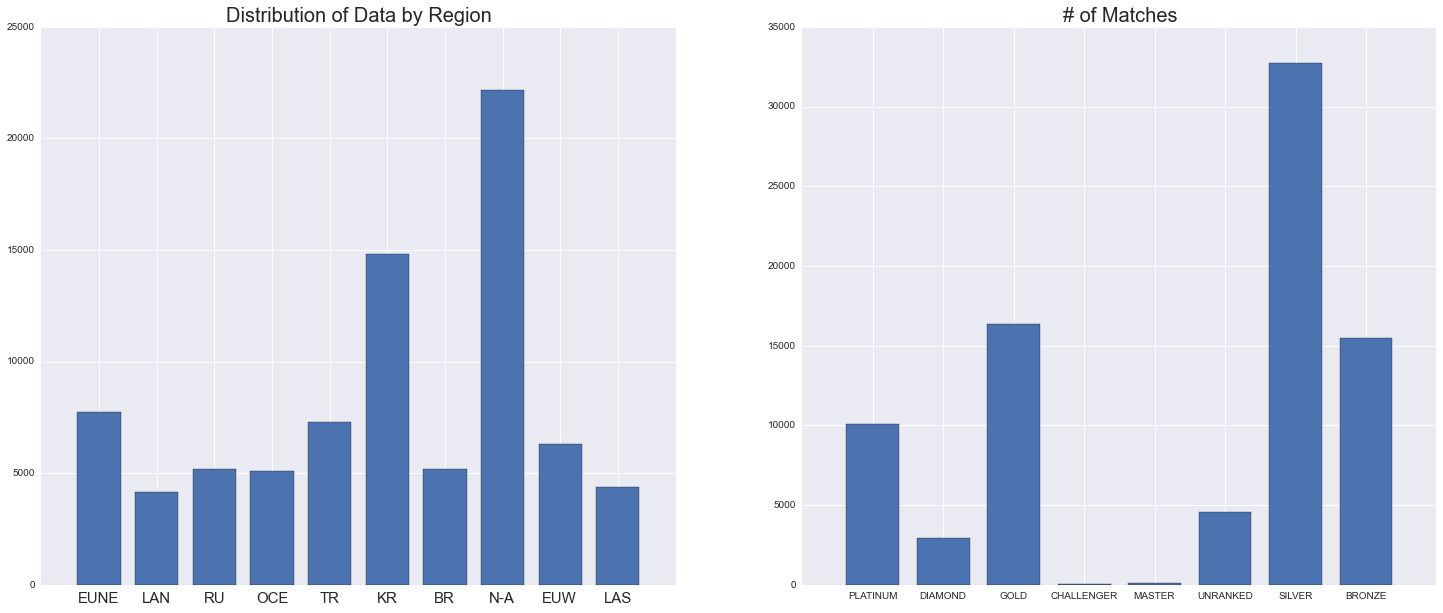

In [8]:
# List of Regions
regions = eda_df['region'].unique()

# Rank Tier Breakdown
region_dist = dict(eda_df['region'].value_counts()/10)
rank_dist = dict(eda_df['match_rank'].value_counts()/10)

print region_dist
print rank_dist

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,10))
ax1.bar(np.arange(len(regions)), region_dist.values(), width=0.75, align='center')
ax1.set_xticks(np.arange(len(regions)))
ax1.set_xticklabels(np.array(region_dist.keys()), size=15)
ax1.set_xlim([-1,10])
ax2.bar(np.arange(len(rank_dist.keys())), rank_dist.values(), width=0.75, align='center')
ax2.set_xticks(np.arange(len(rank_dist.keys())))
ax2.set_xticklabels(rank_dist.keys(), size=10)
ax1.set_title("Distribution of Data by Region", size=20)
ax2.set_title("# of Matches", size=20)

# Two subplots, unpack the axes array immediately
#f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#ax1.plot(x, y)
#ax1.set_title('Sharing Y axis')
#ax2.scatter(x, y)

# Two subplots, the axes array is 1-d
#f, axarr = plt.subplots(2, sharex=True)
#axarr[0].plot(x, y)
#axarr[0].set_title('Sharing X axis')
#axarr[1].scatter(x, y)

#plt.show()
#fig, ax = plt.subplots()
#df['region'].value_counts().plot(ax=ax, kind='barh')
#plt.show()

#fig, axes = plt.subplots(nrows=11, ncols=4, figsize=(16, 44), 
#                         tight_layout=True)
#for ax, p in zip(axes.ravel(), ccols):
#    for k, v in dfgb[p]:
#        sns.kdeplot(v, ax=ax, label=str(k)+":"+v.name)


### Most Popular Champions

### Win/Loss Rate Based on Champion<a id='win_loss_rate'></a>

### KDA by Champion<a id='KDA'></a>

In [9]:
champions=eda_df['champ'].unique()
champions
#a champion name is nan - fix


array(['MissFortune', 'Vladimir', 'Morgana', 'Akali', 'XinZhao',
       'Tristana', 'Blitzcrank', 'Riven', 'Talon', 'Nunu', 'Garen',
       'Karthus', 'Olaf', 'Malphite', 'MasterYi', 'Jinx', 'Zed', 'Nami',
       'Nidalee', 'Rengar', 'Braum', 'Rumble', 'LeeSin', 'Nasus',
       'TwistedFate', 'Thresh', 'Vayne', 'Diana', 'Kayle', 'Leona',
       'Nautilus', 'Yasuo', 'Alistar', 'Darius', 'Lux', 'Jax', 'Draven',
       'Lulu', 'Velkoz', 'Udyr', 'Leblanc', 'Ahri', 'Soraka', 'Caitlyn',
       'Evelynn', 'Lucian', 'Katarina', 'Shen', 'TahmKench', 'Kalista',
       'Rammus', 'Ezreal', 'Hecarim', 'Twitch', 'Brand', 'Renekton',
       'Nocturne', 'DrMundo', 'Illaoi', 'Orianna', 'JarvanIV', 'Graves',
       'Ashe', 'Janna', 'Aatrox', 'Taric', 'Chogath', 'Kindred', 'Syndra',
       'Viktor', 'Volibear', 'Zyra', 'Lissandra', 'Warwick', 'Irelia',
       'Teemo', 'Amumu', 'KogMaw', 'Poppy', 'Fizz', 'Urgot', 'Skarner',
       'Ryze', 'Veigar', 'Vi', 'Malzahar', 'Tryndamere', 'Shyvana',
       'Trundl

In [10]:
cgroup=eda_df.groupby('champ')
champions=eda_df['champ'].unique()
kills=cgroup['kills'].sum()
assists=cgroup['assists'].sum()
deaths=cgroup['deaths'].sum()
kda=(kills+assists)/deaths
newkda=kda.order(ascending=False)
topten=newkda[:10]
np.array(topten.index)

C:\Users\Andrew\Anaconda\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: order is deprecated, use sort_values(...)


array(['Janna', 'Zac', 'Nami', 'Shen', 'Sejuani', 'Anivia', 'Lux', 'Braum',
       'Alistar', 'Amumu'], dtype=object)

In [14]:
#given name of champion and list of ranks to compare, plots horizontal bar chart comparing kda
def KDAcomp(name, cranks):
    champlst=[]
    champdct={}
    for i in cranks:
        tgroup=eda_df.groupby(['champ', 'rank']).get_group((name, i))
        kills=tgroup['kills'].sum()
        assists=tgroup['assists'].sum()
        deaths=tgroup['deaths'].sum()
        champlst.append((kills+assists)/float(deaths))
        champdct[i]=(kills+assists)/float(deaths)
    print champlst
    print champdct
    plt.barh(np.arange(len(cranks)), champlst)
    plt.yticks(np.arange(len(cranks)), cranks)
    plt.xlabel(name + " KDA")
    
    




[2.016260162601626, 1.4042553191489362, 1.5920490928495197, 1.8968989280245023, 1.6994431185361973]
{'UNRANKED': 1.6994431185361973, 'CHALLENGER': 2.016260162601626, 'DIAMOND': 1.5920490928495197, 'MASTER': 1.4042553191489362, 'BRONZE': 1.8968989280245023}


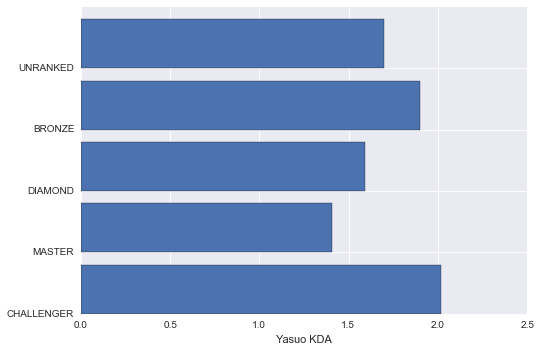

In [12]:
c=['CHALLENGER', 'MASTER', 'DIAMOND', 'BRONZE', 'UNRANKED']
KDAcomp('Yasuo', c)
#do same for warwick

[3.903225806451613, 2.764705882352941, 3.6609271523178806, 3.3803840166061234, 3.164383561643836]
{'UNRANKED': 3.164383561643836, 'CHALLENGER': 3.903225806451613, 'DIAMOND': 3.6609271523178806, 'MASTER': 2.764705882352941, 'BRONZE': 3.3803840166061234}


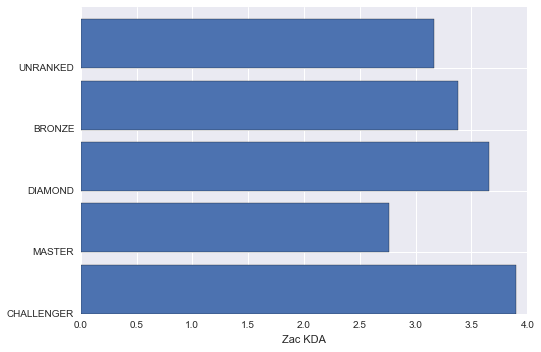

In [13]:
KDAcomp('Zac', c)

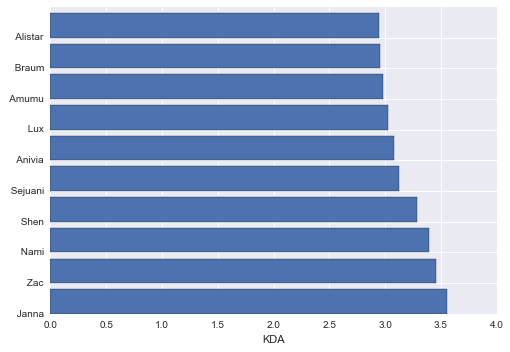

In [75]:
plt.barh(np.arange(10), topten.values)
plt.yticks(np.arange(10), np.array(topten.index))
plt.xlabel("KDA")

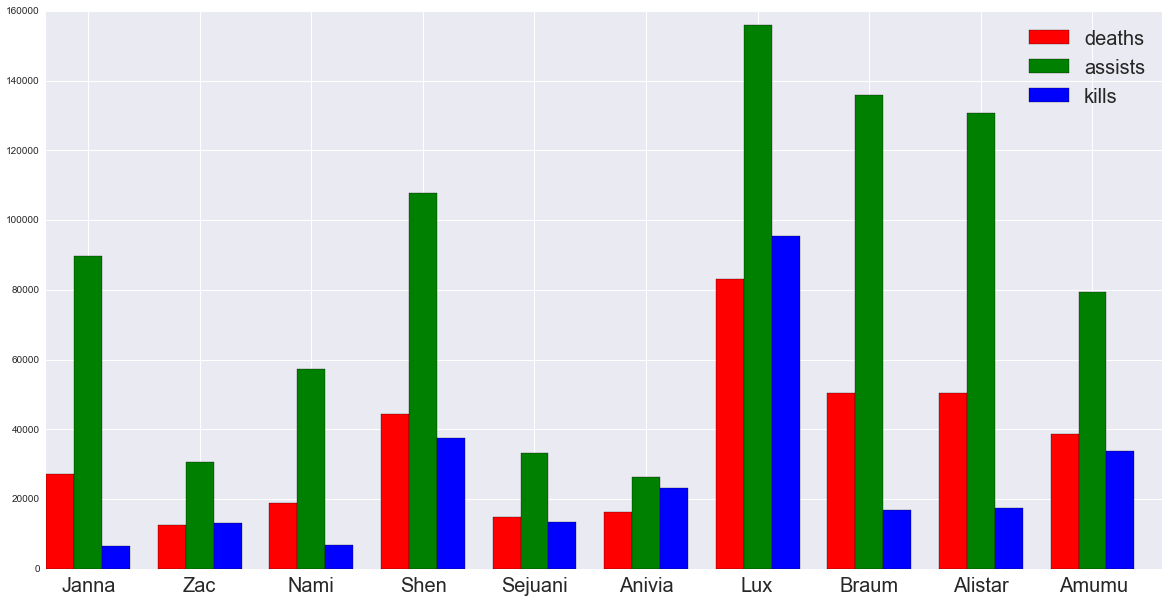

In [71]:
#np.array(deaths)
ttchampions=np.array(topten.index)
dt=[]
at=[]
kt=[]
for i in ttchampions:
    dt.append(deaths[i])
    at.append(assists[i])
    kt.append(kills[i])

d=np.arange(len(ttchampions))*3
w=0.75
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(d, dt, w, color='red', label='deaths')
ax.bar(d+w, at, w, color='green', label='assists')
ax.bar(d+2*w, kt, w, color='blue', label='kills')
ax.set_xticks(d+3*w/2)
ax.set_xticklabels(ttchampions, size=20)
ax.legend(fontsize=20)

### Champions by Stat<a id='champion-stat'></a>

In [72]:
# champion with largest average number of kills

klist=cgroup['kills'].agg(np.mean)
kmax=klist.idxmax()

quantcolumns=['total_heal',
'wards_placed',
'cc_dealt',
'jungle_killed',
'creep_score',
'damage_taken',
'max_crit',
'max_multi_kill',
'gold_earned',
'p_damage_to_champs',
'm_damage_to_champs',
'deaths']
bestchamp={}
for i in quantcolumns:
    holder=cgroup[i].agg(np.mean)
    bestchamp[i]=holder.idxmax()

bestchamp

{'cc_dealt': 'Anivia',
 'creep_score': 'Gangplank',
 'damage_taken': 'Warwick',
 'deaths': 'Akali',
 'gold_earned': 'Gangplank',
 'jungle_killed': 'MasterYi',
 'm_damage_to_champs': 'Karthus',
 'max_crit': 'Caitlyn',
 'max_multi_kill': 'Katarina',
 'p_damage_to_champs': 'Quinn',
 'total_heal': 'Zac',
 'wards_placed': 'Janna'}

In [73]:
#given feature, return top 3, middle 3, and bottom 3 champions of that feature in a dictionary?

def topmiddlebottom(fn):
    c=cgroup[fn].agg(np.mean)
    cn=c.order(ascending=False)
    tmb={}
    tmblist=[]
    tmb['bottom']=np.array(cn[-3:].index)
    tmblist.append(list(cn[-3:].index))
    tmb['middle']=np.array(cn[64:67].index)
    tmblist.append(list(cn[64:67].index))
    tmb['top']=np.array(cn[:3].index)
    tmblist.append(list(cn[:3].index))
    
    #flatten tmblist
    tmblist=[item for sublist in tmblist for item in sublist]
    return tmb, tmblist

In [74]:
#given a champion, a list, and a colormap, it returns the color corresponding to the champion relative to that list
#red means bottom, blue means middle, green means top
colormap=['red', 'blue','green']

def colorfunc(a, lst, cmap=colormap):
    i=lst.index(a)
    if i<=2:
        return cmap[0]
    elif i<=5:
        return cmap[1]
    else:
        return cmap[2]
    

['Zyra', 'Morgana', 'Yasuo', 'Nautilus', 'Braum', 'Kalista', 'Zac', 'Soraka', 'Vladimir'] ['Caitlyn', 'Draven', 'Nasus', 'Zed', 'Jayce', 'Fizz', 'Janna', 'Nami', 'Thresh']
['Soraka', 'Nami', 'Janna', 'Tristana', 'Jinx', 'Corki', 'MasterYi', 'Udyr', 'Shyvana'] ['Soraka', 'Nami', 'Janna', 'Sion', 'Akali', 'Diana', 'Gangplank', 'Lucian', 'Graves']
['Azir', 'Swain', 'Singed', 'JarvanIV', 'RekSai', 'Warwick', 'Caitlyn', 'Gangplank', 'Draven'] ['Alistar', 'Janna', 'Soraka', 'Rumble', 'Velkoz', 'Sivir', 'Katarina', 'MasterYi', 'Akali']
['Viktor', 'FiddleSticks', 'Karthus', 'Rammus', 'Malphite', 'Blitzcrank', 'Quinn', 'Draven', 'Illaoi'] ['Sivir', 'Twitch', 'Riven', 'Shaco', 'Bard', 'Warwick', 'Karthus', 'Brand', 'Ziggs']


C:\Users\Andrew\Anaconda\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: order is deprecated, use sort_values(...)


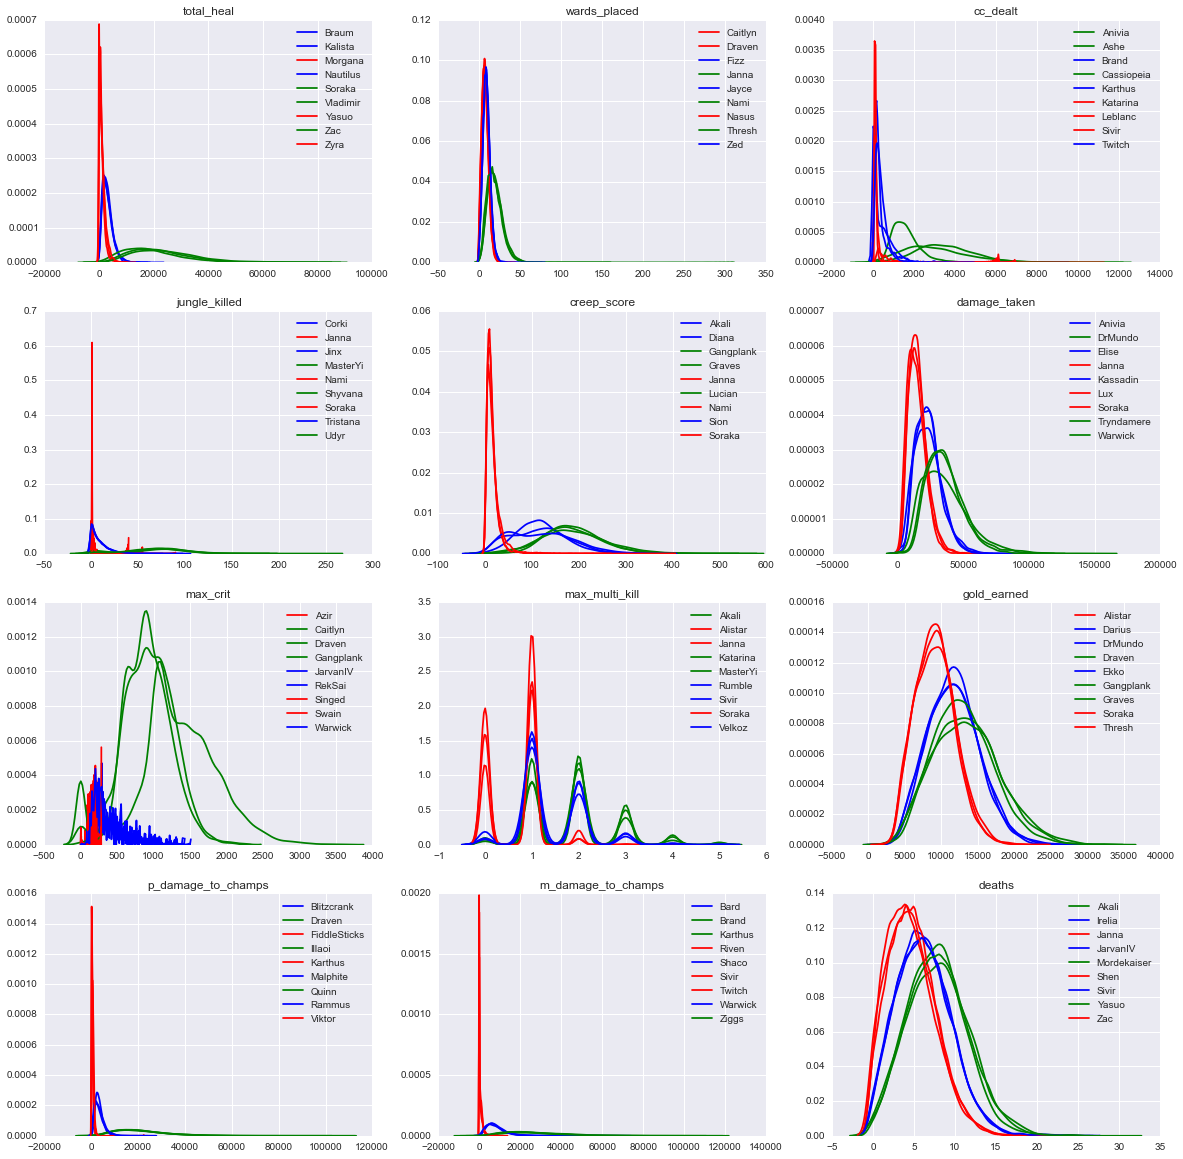

In [75]:
# pretty sure this is useless. just shows that the top 10 earners of gold don't have that different earnings in gold.
#maybe could indicate by how compact the curves are relative to teach other that some champions have more variation in 
#gold earning than others?




fig, ax = plt.subplots(4,3, figsize=(20,20))
for index, row in enumerate(ax):
    f1name=quantcolumns[index*3]
    f1dict, f1list=topmiddlebottom(f1name)
    f2name=quantcolumns[index*3+1]
    f2dict, f2list=topmiddlebottom(f2name)
    f3name=quantcolumns[index*3+2]
    f3dict, f3list=topmiddlebottom(f3name)
    row[0].set_title(f1name)
    row[1].set_title(f2name)
    row[2].set_title(f3name)
    for g, data in cgroup:
        if g in f1list:
            sns.kdeplot(data[f1name], ax = row[0], label=g, color=colorfunc(g, f1list))
        if g in f2list:
            sns.kdeplot(data[f2name], ax = row[1], label=g, color=colorfunc(g, f2list))
        if g in f3list:
            sns.kdeplot(data[f3name], ax = row[2], label=g, color=colorfunc(g, f3list))
    
#red means bottom, blue means middle, green means top

        
    

In [81]:
print 'hey'

hey


In [15]:
#most commonly used pairs

#create a dict with all pair combinations as keys
#iterate through data set and keep a tally of pairs that show up in games


import itertools
d=itertools.combinations(champions, 2)

#creating a dictionary of pair combinations as keys
pairdict={}
for i in d:
    pairdict[i]=0


pgroup=eda_df.groupby(['match_ID', 'win'])
for g, data in pgroup:
    k=itertools.combinations(data['champ'],2)
    for a,b in k:
        if (a,b) in pairdict:
            pairdict[(a,b)]+=1
        else:
            pairdict[(b,a)]+=1
        
        
#create combinations of champion pairs in each team
#iterate through combinations and add 1 to the value in the dictionary
        
    

In [18]:
#turn dictionary into key value pairs and sort on values
import operator
sorted_x = sorted(pairdict.items(), key=operator.itemgetter(1))

In [20]:
#how should i visualize this now?

[(('Tristana', 'LeeSin'), 3049),
 (('Blitzcrank', 'Vayne'), 3083),
 (('LeeSin', 'Thresh'), 3614),
 (('Thresh', 'Vayne'), 3937),
 (('LeeSin', 'Vayne'), 4473)]

### Standardization

In [76]:
STANDARDIZABLE = [u'kills', u'assists', u'deaths', u'gold_earned',
       u'p_damage_to_champs', u'm_damage_to_champs', u'damage_taken', u'creep_score',
       u'jungle_killed', u'cc_dealt', u'wards_placed', u'total_heal']
BINARY = [u'max_multi_kill', u'max_crit',u'no_killing_spree']

In [77]:
eda_df.tail(10)

,region,match_ID,participant,rank,match_rank,champ,win,kills,assists,deaths,...,m_damage_to_champs,max_multi_kill,max_crit,damage_taken,no_killing_spree,creep_score,jungle_killed,cc_dealt,wards_placed,total_heal
823620,TR,332063081,1,SILVER,SILVER,Veigar,0,4,7,8,...,9590,1,0,17593,1,119,0,139,6,1313
823621,TR,332063081,2,UNRANKED,SILVER,Nidalee,0,3,8,13,...,13077,2,827,33314,1,122,1,51,3,8539
823622,TR,332063081,3,SILVER,SILVER,Tryndamere,0,10,6,10,...,1990,1,773,55279,2,197,25,206,10,11629
823623,TR,332063081,4,SILVER,SILVER,Gragas,0,9,5,9,...,22150,3,498,58790,2,141,48,1174,12,23609
823624,TR,332063081,5,BRONZE,SILVER,Taric,0,1,16,10,...,6302,1,0,36687,0,44,0,1457,8,14506
823625,TR,332063081,6,SILVER,SILVER,Lucian,1,8,10,4,...,4640,1,518,18244,1,222,14,0,4,2444
823626,TR,332063081,7,BRONZE,SILVER,Thresh,1,4,14,5,...,8634,1,0,18682,1,15,0,458,15,1304
823627,TR,332063081,8,SILVER,SILVER,Illaoi,1,3,7,9,...,1211,1,0,34832,0,150,1,205,7,6904
823628,TR,332063081,9,BRONZE,SILVER,Shaco,1,28,4,5,...,18224,2,1364,30891,4,108,86,1239,13,6214
823629,TR,332063081,10,BRONZE,SILVER,Lux,1,7,16,4,...,27129,1,0,14492,2,106,6,161,5,1226


In [78]:
normalized=eda_df.copy()
normalized.head(20)

,region,match_ID,participant,rank,match_rank,champ,win,kills,assists,deaths,...,m_damage_to_champs,max_multi_kill,max_crit,damage_taken,no_killing_spree,creep_score,jungle_killed,cc_dealt,wards_placed,total_heal
0,OCE,113859173,1,SILVER,SILVER,MissFortune,0,10,10,7,...,2542,2,878,25178,3,253,18,506,5,4450
1,OCE,113859173,2,SILVER,SILVER,Vladimir,0,12,7,9,...,35581,1,0,47495,4,268,1,667,12,32996
2,OCE,113859173,3,UNRANKED,SILVER,Morgana,0,0,9,7,...,5745,0,0,14913,0,40,0,968,16,140
3,OCE,113859173,4,UNRANKED,SILVER,Akali,0,12,9,13,...,17557,2,0,39497,2,81,0,975,6,598
4,OCE,113859173,5,GOLD,SILVER,XinZhao,0,5,10,12,...,6175,1,173,44762,0,53,52,1852,15,11141
5,OCE,113859173,6,SILVER,SILVER,Tristana,1,9,10,6,...,4333,2,681,24242,2,234,11,144,6,5231
6,OCE,113859173,7,UNRANKED,SILVER,Blitzcrank,1,5,15,7,...,5739,1,0,31238,1,20,1,112,18,5104
7,OCE,113859173,8,SILVER,SILVER,Riven,1,9,10,13,...,0,2,0,32805,1,172,12,237,7,436
8,OCE,113859173,9,GOLD,SILVER,Talon,1,15,8,10,...,243,2,0,35775,3,193,16,877,14,2683
9,OCE,113859173,10,GOLD,SILVER,Nunu,1,10,18,3,...,25176,2,0,54151,3,62,95,2535,17,22512


In [79]:
%%time
normalized[STANDARDIZABLE] = normalized.groupby(['match_ID', 'region', 'win']).transform(lambda x: (x/x.sum() if x.sum() != 0 else 0))[STANDARDIZABLE]

Wall time: 11min 47s


In [39]:
print normalized.isnull().values.any()
print pd.isnull(normalized).any(1).nonzero()[0]

False
[]


In [50]:
%%time
normalized[BINARY] = normalized.groupby(['match_ID', 'region', 'win']).transform(lambda x: (x == x.max()))[BINARY]

Wall time: 1min 37s


### PART III: Clustering Algorithms<a id='clustering'></a>

In [53]:
clusteringdf=normalized.ix[:, 'kills':]
clusteringdf.head()

,kills,assists,deaths,gold_earned,p_damage_to_champs,m_damage_to_champs,max_multi_kill,max_crit,damage_taken,no_killing_spree,creep_score,jungle_killed,cc_dealt,wards_placed,total_heal
0,0.256410,0.222222,0.145833,0.243140,0.658047,0.037604,True,True,0.146516,False,0.364029,0.253521,0.101852,0.092593,0.090218
1,0.307692,0.155556,0.187500,0.244591,0.029887,0.526346,False,False,0.276383,True,0.385612,0.014085,0.134259,0.222222,0.668951
2,0.000000,0.200000,0.145833,0.148516,0.010623,0.084985,False,False,0.086782,False,0.057554,0.000000,0.194847,0.296296,0.002838
3,0.307692,0.200000,0.270833,0.183806,0.078024,0.259719,True,False,0.229841,False,0.116547,0.000000,0.196256,0.111111,0.012124
4,0.128205,0.222222,0.250000,0.179948,0.223418,0.091346,False,False,0.260479,False,0.076259,0.732394,0.372786,0.277778,0.225869


In [55]:
df=pd.read_csv('training_full_v3.csv')
dftouse=df
dftouse.tail(20)

,Win,FirstBlood,FirstTower,FirstTowerAssist,Kills,Assists,Deaths,GoldEarned,TotalDamageDealt,MagicDamageDealt,...,TotalDamageTaken,MinionsKilled,NeutralMinionsKilled,CrowdControl,WardsPlaced,TowerKills,LargestMultiKill,LargestKillingSpree,LargestCritStrike,TotalHealAmount
124710,1,0.0,0.0,0,0.120000,0.050000,0.000000,0.182745,0.254018,0.544928,...,0.070968,0.328804,0.000000,0.000000,0.240000,1.000000,0,0,0,0.031127
124711,1,0.0,0.0,0,0.200000,0.300000,0.272727,0.200693,0.154438,0.274293,...,0.185344,0.149457,0.000000,0.114551,0.480000,0.000000,1,0,0,0.591665
124712,1,0.1,0.0,0,0.360000,0.250000,0.363636,0.225285,0.197131,0.000000,...,0.235265,0.192935,0.000000,0.222910,0.160000,0.000000,1,0,1,0.000000
124713,1,0.0,0.0,0,0.080000,0.350000,0.363636,0.195973,0.263470,0.000000,...,0.317754,0.078804,0.944444,0.380805,0.000000,0.000000,0,0,0,0.358086
124714,1,0.0,0.0,0,0.240000,0.050000,0.000000,0.195303,0.130942,0.180779,...,0.190669,0.250000,0.055556,0.281734,0.120000,0.000000,1,1,0,0.019122
124715,0,0.0,0.0,0,0.200000,0.363636,0.320000,0.190695,0.223791,0.124699,...,0.296438,0.028302,1.000000,0.361146,0.034483,0.000000,0,0,0,0.193747
124716,0,0.0,0.0,0,0.000000,0.090909,0.040000,0.176965,0.271456,0.469419,...,0.160258,0.279874,0.000000,0.545455,0.206897,0.000000,0,0,0,0.362951
124717,0,0.0,0.0,0,0.100000,0.000000,0.080000,0.204464,0.232176,0.229093,...,0.111343,0.361635,0.000000,0.006227,0.172414,0.000000,0,0,0,0.150281
124718,0,0.0,0.0,0,0.200000,0.272727,0.240000,0.183446,0.063018,0.083478,...,0.207549,0.084906,0.000000,0.063512,0.379310,0.000000,0,0,0,0.118881
124719,0,0.0,0.0,0,0.500000,0.272727,0.320000,0.244429,0.209559,0.093312,...,0.224412,0.245283,0.000000,0.023661,0.206897,0.000000,1,1,1,0.174140


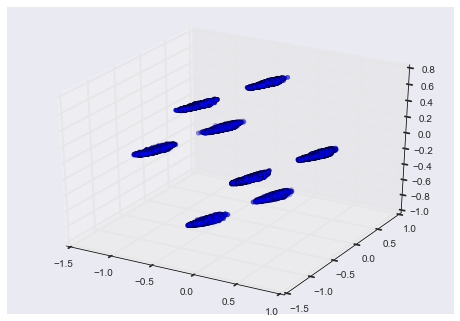

In [54]:
# Normalization shrinks all values to some distribution around a mean of 0. 

from sklearn.decomposition import PCA
pca=PCA(n_components=3)
pca.fit(clusteringdf)
dnew=pca.transform(clusteringdf)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

first=[i[0] for i in dnew]
second=[i[1] for i in dnew]
third=[i[2] for i in dnew]

ax.scatter(first, second, third)

In [108]:
pca.components_

array([[-0.42085319,  0.13976412,  0.11218345, -0.42699891, -0.34925076,
         0.04047502, -0.35203613, -0.26414404,  0.00226591, -0.38679241,
        -0.31957053, -0.05663432, -0.01771902,  0.18875663,  0.01517372],
       [ 0.10697033,  0.11796718, -0.11568842,  0.09669604, -0.06389705,
         0.01059634,  0.08060313, -0.15511791,  0.38159201,  0.10637816,
        -0.31981514,  0.50475966,  0.40752477,  0.07437952,  0.48119856],
       [-0.17540559, -0.35181096,  0.38082927, -0.17415308,  0.30161231,
        -0.51109078, -0.12788701,  0.2576091 ,  0.32885818, -0.17535962,
         0.02721464,  0.16864254, -0.03579033, -0.23877458,  0.09394951]])

###Standardization<a id='standardization'></a>
Let's talk about this. The paper does it by team. How should we do it?


In [58]:
%%time

from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()

clf=GridSearchCV(knn, param_grid={'n_neighbors': [24,6,8,10,12,14,16,18,20]}, scoring='precision', cv=5)
y=normalized['win']
X=clusteringdf
clf.fit(X,y)

Wall time: 2h 3min 50s


In [59]:
clf.best_params_

{'n_neighbors': 14}